In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00


In [5]:
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Input, BatchNormalization, Bidirectional

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
edges = pd.read_csv("/content/drive/MyDrive/Projekt_SSN/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features = pd.read_csv("/content/drive/MyDrive/Projekt_SSN/elliptic_bitcoin_dataset/elliptic_txs_features.csv",header=None)
classes = pd.read_csv("/content/drive/MyDrive/Projekt_SSN/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")

In [7]:
features.rename(columns = {0:'txId1'}, inplace = True)
features = pd.merge(features, edges.groupby('txId1').count(), on="txId1", how="left")
features.head()

,txId1,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,txId2
0,230425980,1,-0.056189,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133295,...,-0.582752,1.442895,1.440189,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,1.0
1,5530458,1,-0.056193,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133311,...,0.702410,-1.033609,-1.032884,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,1.0
2,232022460,1,-0.056378,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133972,...,0.467009,-1.033609,-1.032884,-0.106566,-0.113936,-0.135784,-0.186659,-0.102834,-0.102128,2.0
3,232438397,1,0.043005,0.743641,-0.644127,2.874647,-0.068726,2.304311,3.142835,-0.134902,...,-0.595477,0.204643,0.203652,0.994235,0.099367,-0.135784,0.669253,-0.102834,-0.102128,1.0
4,230460314,1,0.294595,-0.131268,-1.185821,0.125213,0.375512,0.188604,-0.101009,-0.134776,...,-0.380435,0.484856,0.546219,0.003514,0.312670,0.369103,1.281230,0.201809,0.202687,8.0


In [8]:
y = classes[classes['class'] != 'unknown']
x = features[features.iloc[:, 0].isin(y['txId'])]
x = x.iloc[:, 2:]
x.fillna(0, inplace=True)
y['class']=y['class'].apply(lambda x: x=='1')
y = y.iloc[:, 1]
x_train, x_test, y_train, y_test= train_test_split(x,y)
y_train.head()

<ipython-input-8-3fde43f3ce7d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['class']=y['class'].apply(lambda x: x=='1')


117842     True
115964    False
65340     False
17785     False
19474     False
Name: class, dtype: bool

In [9]:
x_train['txId2']=x_train['txId2'].apply(lambda x: np.log(1+x))
x_train.head()

,2,3,4,5,6,7,8,9,10,11,...,158,159,160,161,162,163,164,165,166,txId2
117842,-0.049023,-0.142343,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.107630,-0.074283,-0.024475,...,0.269781,-1.033609,-1.032884,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,0.693147
115964,0.457263,-0.111812,0.980956,-0.186390,0.375512,-0.167505,-0.101009,1.705465,0.930609,-0.024475,...,-0.227076,0.015575,0.006700,-0.106566,1.635150,1.159829,0.294282,0.032241,0.079886,1.386294
65340,-0.041165,-0.131268,-1.185821,-0.186390,0.042333,-0.167505,-0.101009,-0.079490,-0.058687,-0.024475,...,-0.578511,0.204643,0.203652,-0.106566,-0.049945,-0.046947,-0.143864,0.116170,0.117000,1.791759
17785,-0.055183,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.129694,-0.086512,-0.024475,...,-0.468233,1.442895,1.440189,-0.106566,-0.092606,-0.084494,-0.143864,-1.775510,-1.775746,0.693147
19474,-0.056315,-0.158739,0.980956,-0.168061,0.264452,-0.146557,-0.101009,-0.134665,-0.088890,-0.022832,...,2.308862,0.586101,0.584582,-0.106566,0.355331,0.263159,-0.068971,-0.618122,-0.617706,0.000000


(array([4.6556e+04, 4.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,  47.2,  94.4, 141.6, 188.8, 236. , 283.2, 330.4, 377.6,
        424.8, 472. ]),
 <BarContainer object of 10 artists>)

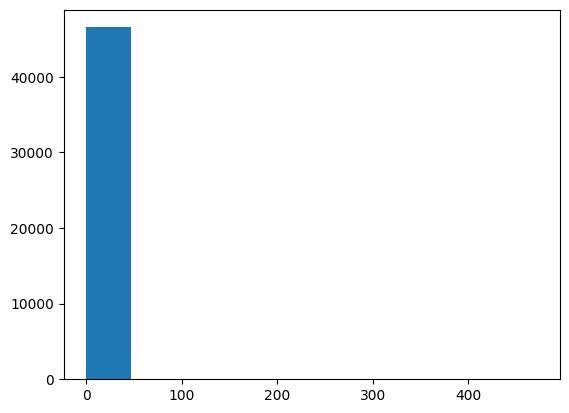

In [10]:
plt.hist(x['txId2'])

(array([8.8630e+03, 2.4585e+04, 8.7700e+02, 3.7900e+02, 1.6000e+02,
        4.8000e+01, 7.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([0.        , 0.56664267, 1.13328534, 1.69992801, 2.26657068,
        2.83321334, 3.39985601, 3.96649868, 4.53314135, 5.09978402,
        5.66642669]),
 <BarContainer object of 10 artists>)

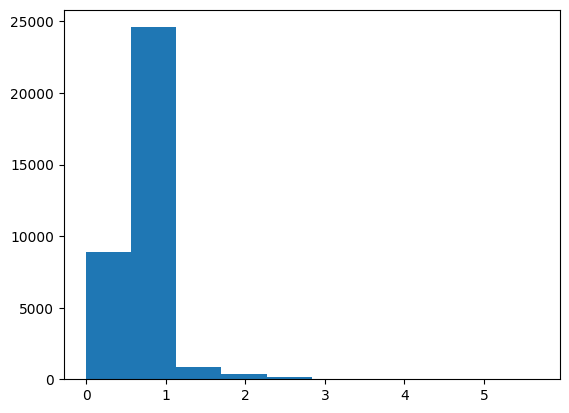

In [21]:
plt.hist(x_train['txId2'])

In [27]:
model = Sequential()


model.add(Bidirectional(LSTM(64, return_sequences=True),
                             input_shape=(x_train.shape[1], 1)))
#model.add(Bidirectional(LSTM(64)))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss=['binary_crossentropy'] , optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

loss, accuracy = model.evaluate(x_test, y_test)

Epoch 1/5
1092/1092 [==============================] - 245s 219ms/step - loss: 0.2677 - accuracy: 0.9058 - val_loss: 0.2489 - val_accuracy: 0.9030
Epoch 2/5
1092/1092 [==============================] - 257s 235ms/step - loss: 0.2399 - accuracy: 0.9117 - val_loss: 0.2265 - val_accuracy: 0.9149
Epoch 3/5
1092/1092 [==============================] - 238s 218ms/step - loss: 0.2205 - accuracy: 0.9172 - val_loss: 0.2054 - val_accuracy: 0.9223
Epoch 4/5
1092/1092 [==============================] - 234s 214ms/step - loss: 0.1949 - accuracy: 0.9299 - val_loss: 0.1875 - val_accuracy: 0.9389
Epoch 5/5
364/364 [==============================] - 22s 61ms/step - loss: 0.1932 - accuracy: 0.9330


In [28]:
loss, accuracy = model.evaluate(x_test, y_test)

364/364 [==============================] - 22s 60ms/step - loss: 0.1932 - accuracy: 0.9330


In [29]:
y = classes[classes['class'] == 'unknown']
x = features[features.iloc[:, 0].isin(y['txId'])]
x = x.iloc[:, 2:]
x.fillna(0, inplace=True)
x['txId2']=x['txId2'].apply(lambda x: np.log(1+x))
result=model.predict(x)

4913/4913 [==============================] - 270s 55ms/step


In [30]:
res=np.round(result)

In [31]:
unique, counts = np.unique(res, return_counts=True)
dict(zip(unique, counts))

{0.0: 23633797, 1.0: 2462233}

In [32]:
classes_illicit = classes[classes['class'] == '1']
classes_licit = classes[classes['class'] == '2']
classes_illicit.count()/classes_licit.count()

txId     0.108165
class    0.108165
dtype: float64

In [33]:
counts[1]/counts[0]

0.10418270919395643